## Simple guassian anomaly detection algorithm

This is simply meant to show the inner workings of a anomaly detection algorithm based on the gaussian distribution. Note - I will be implementing both two techniques, one using normal gaussian distribution and one using a multivariate guassian distribution. 

In order to simulate anomalies, I will be using a classification dataset and I will using one of the classes to define "normal" and the other class to represent examples of anomalies. Specifically, I will be using a dataset of features corresponding to individuals that have breast cancer and those that don't.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import datasets
from scipy.stats import norm
import latex
import random
import math
import seaborn as sns
from sklearn.model_selection import train_test_split

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
# I will be first reading in all the features and determining which features would be good for anomaly analysis
bc = datasets.load_breast_cancer()
X = bc.data[:,:30]  # 30x features for analysis
y = bc.target
# Separating data by classification

In [3]:
# Separating the data by classification and choosing the classification with the larger number to represent "normal"
X_0 = [X[i,:] for i in range(len(y)) if y[i] == 0]
y_0 = [y[i] for i in range(len(y)) if y[i] == 0]
X_1 = [X[i,:] for i in range(len(y)) if y[i] == 1]
y_1 = [y[i] for i in range(len(y)) if y[i] == 1]
X_0 = np.array(X_0)
X_1 = np.array(X_1)
print("shape of X_0: {},length of y_0: {}".format(X_0.shape, len(y_0)))
print("shape of X_1: {},length of y_1: {}".format(X_1.shape, len(y_1)))
assert(len(y_0)+len(y_1)==569)

shape of X_0: (212, 30),length of y_0: 212
shape of X_1: (357, 30),length of y_1: 357


In [4]:
# Class 1 has more observations so I will classify it as "normal", and class 0 is "abnormal"
normal = X_1
anomalies = X_0
anomaly = anomalies[:20] # subset of anomalies for representative purposes

### Visualy analyzing the distribution of each of my features to see which I should keep

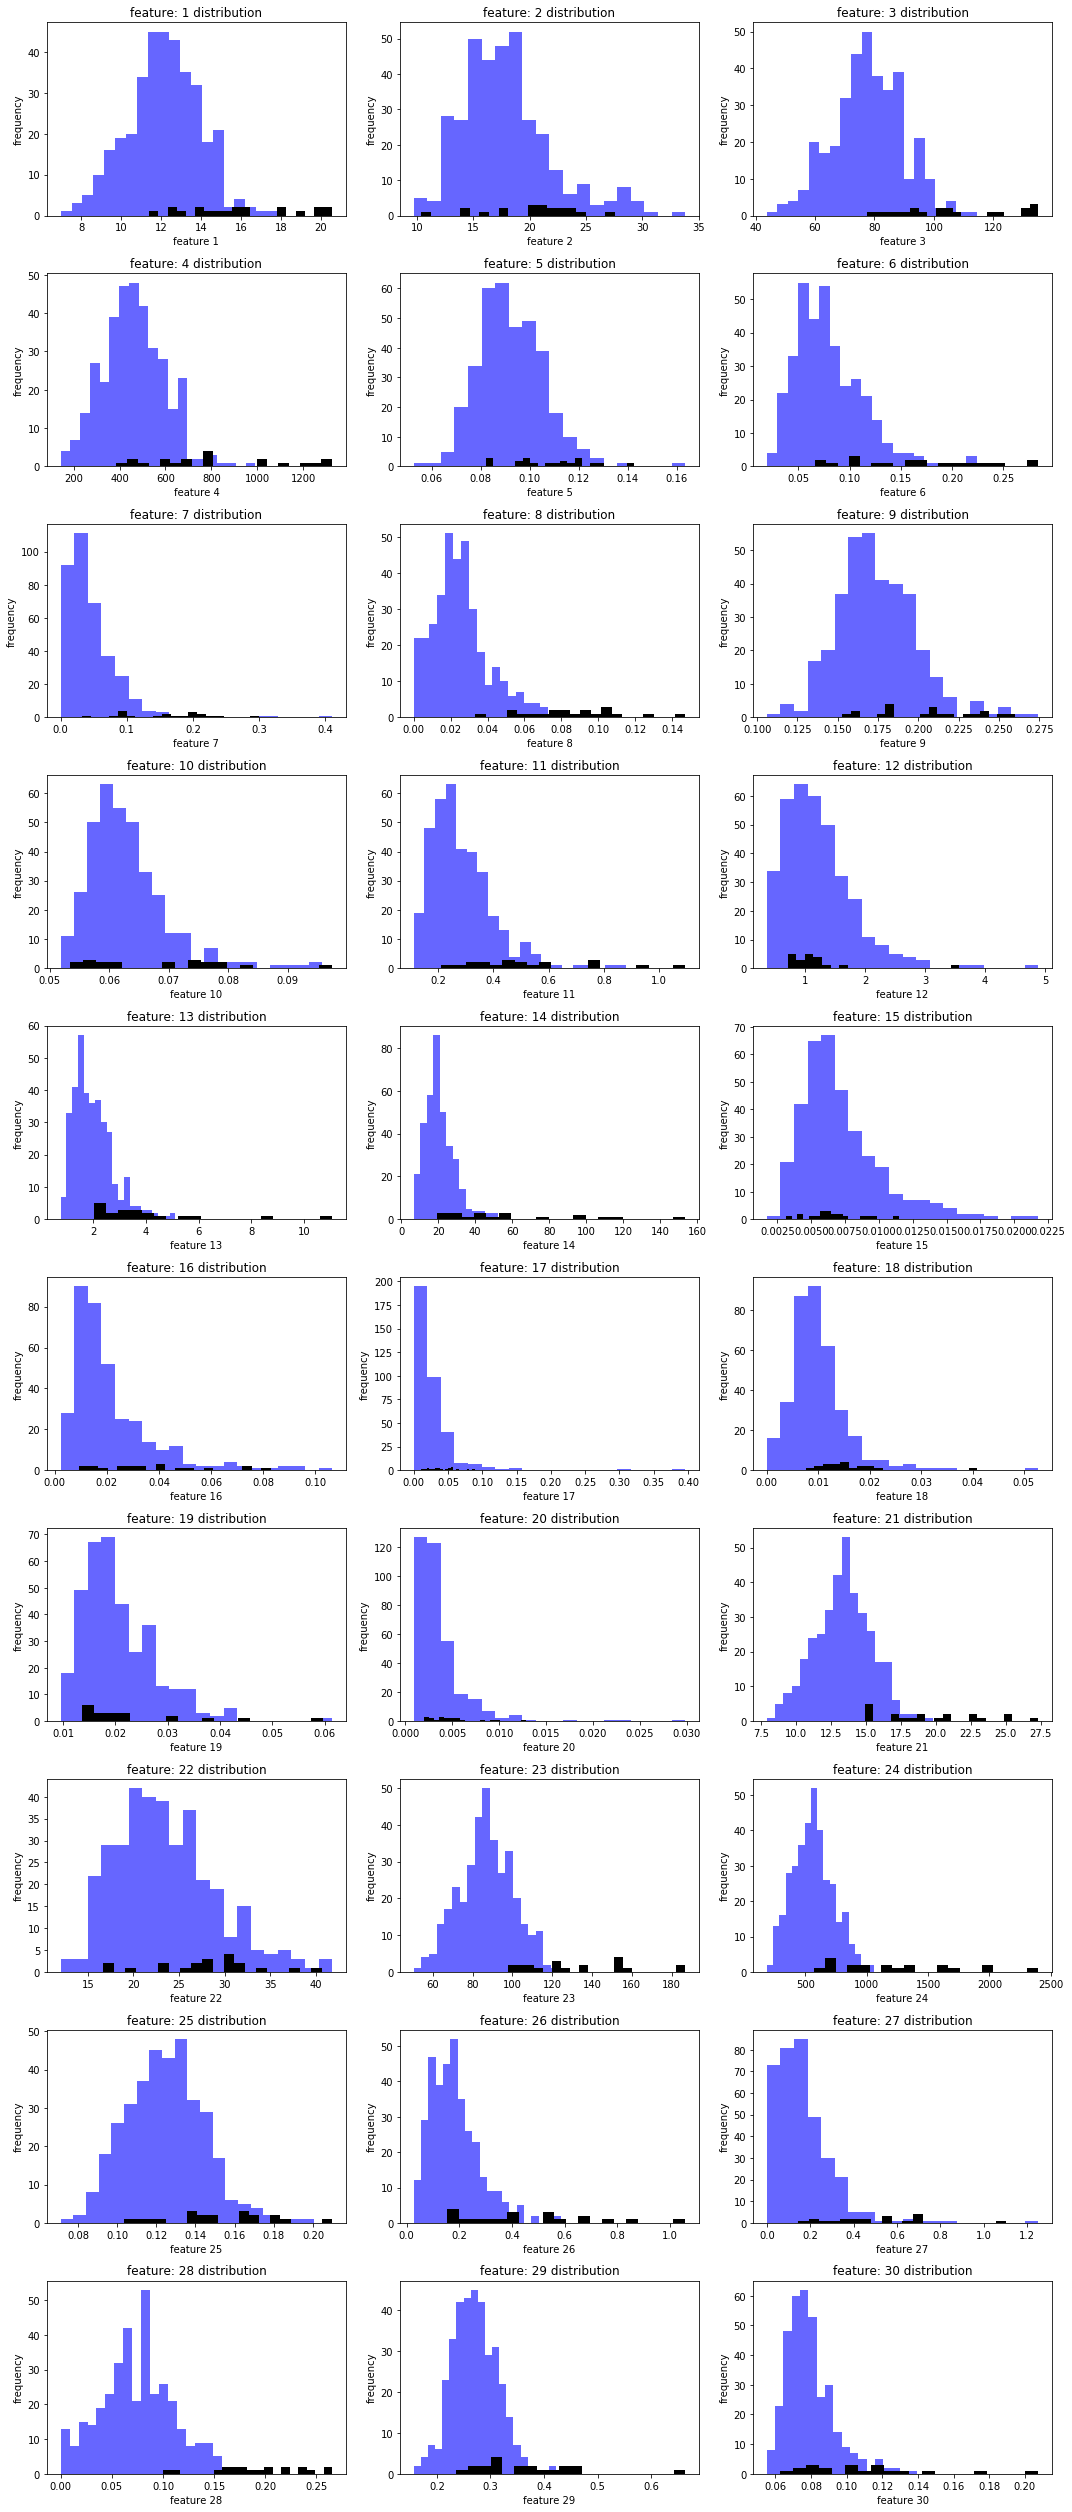

In [5]:
# Anomalies are represented by the color black and normal values are represented by the color blue
plt.figure(figsize=[15, 35])
for i in range(1,31):
    plt.subplot(10, 3, i)
    plt.hist(normal[:,i-1],color='blue',alpha=0.6,bins=20)
    plt.hist(anomaly[:,i-1],color='black',alpha=1,bins=20)
    plt.title("feature: "+str(i)+" distribution")
    plt.xlabel("feature "+str(i))
    plt.ylabel("frequency")
    plt.tight_layout()
    
plt.show()

#### I firstly see that essentially all of the features are nearly normally distributed. Secondly, from these plots I am able to see which features will be good in my anomaly detection model.

Specifically, feature 21,23,24,and 28 have the highest variation in values between "normal" examples and anomaly examples.

In [6]:
final_features_normal = np.take(normal,[20,22,23,27],axis=1)
final_features_anomaly = np.take(anomaly,[20,22,23,27],axis=1)
print("normal data shape:",final_features_normal.shape)
print("anomaly data shape:",final_features_anomaly.shape)

normal data shape: (357, 4)
anomaly data shape: (20, 4)


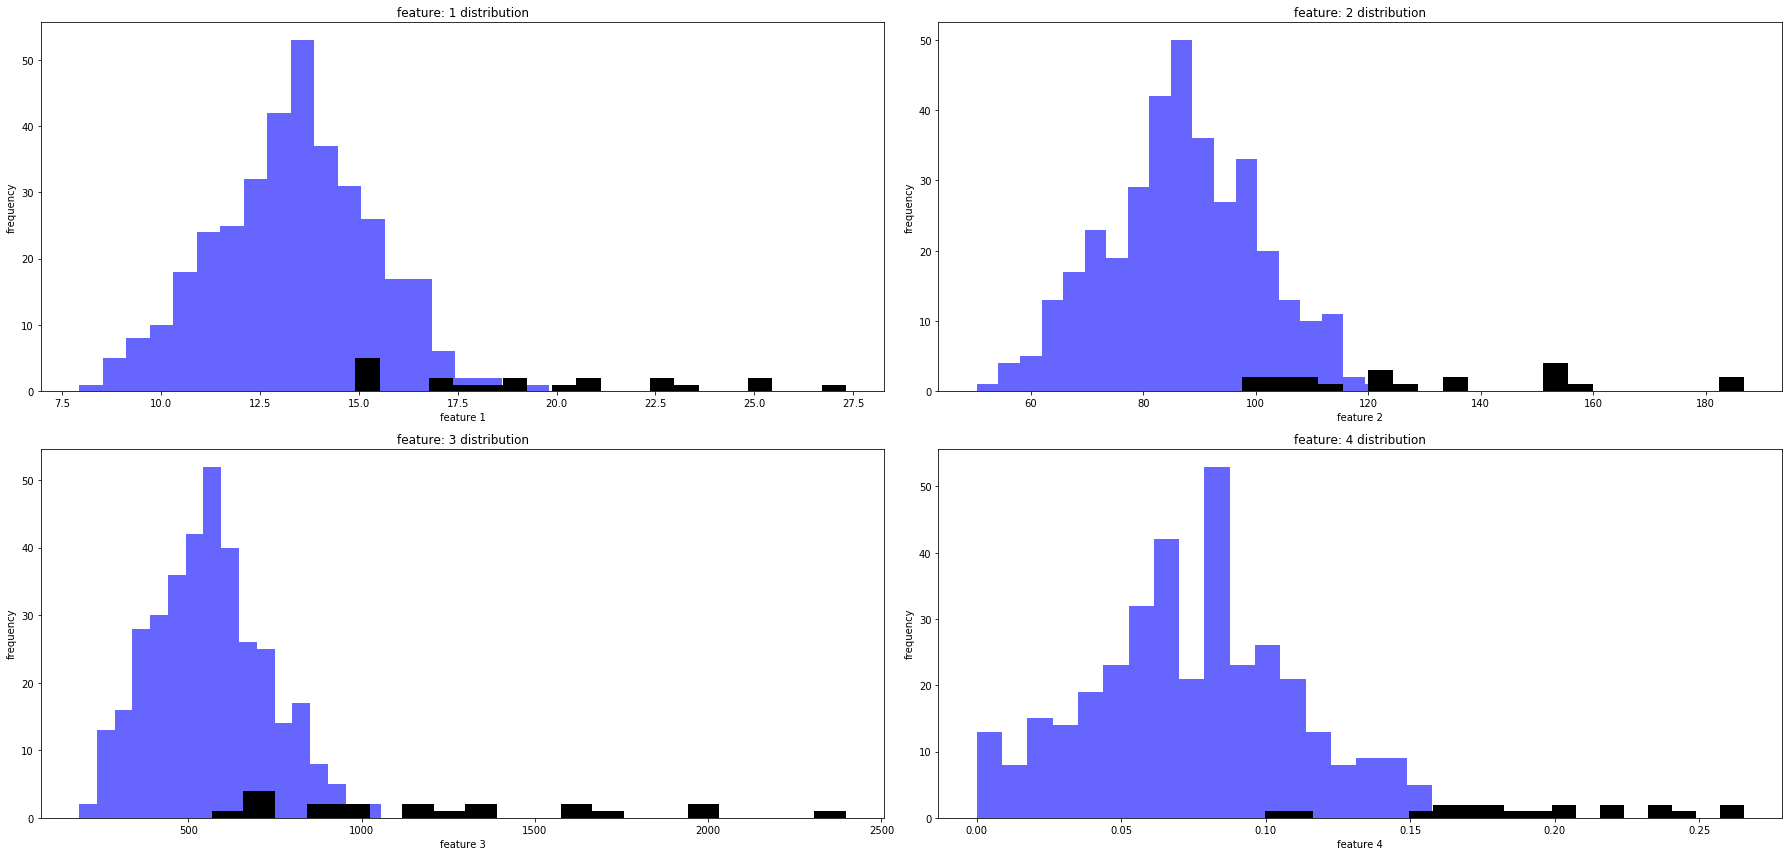

In [7]:
# Visualizing the final features independantly as they relate to anomaly observations
# These seem like good features for my anomaly detection algorithm
plt.figure(figsize=[25, 12])
for i in range(1,5):
    plt.subplot(2, 2, i)
    plt.hist(final_features_normal[:,i-1],color='blue',alpha=0.6,bins=20)
    plt.hist(final_features_anomaly[:,i-1],color='black',alpha=1,bins=20)
    plt.title("feature: "+str(i)+" distribution")
    plt.xlabel("feature "+str(i))
    plt.ylabel("frequency")
    plt.tight_layout()
    
plt.show()

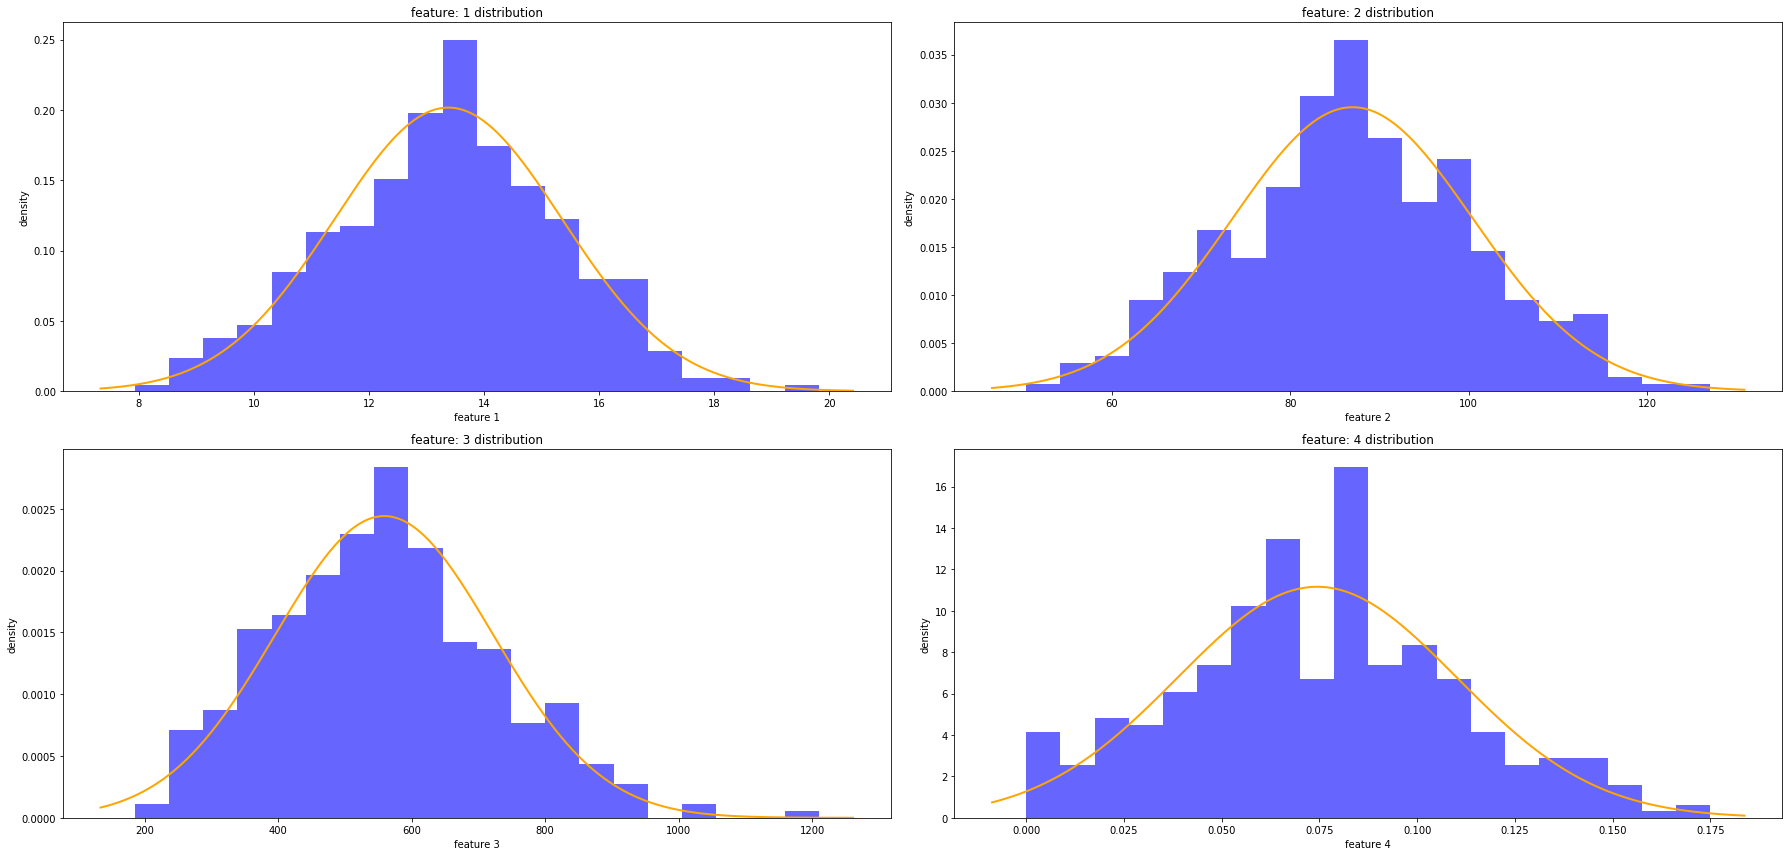

In [8]:
# Visualizing all of the features for normal data as they relate to their density distribution
# All of the features look relatively normal so I am not going to do any transformations
plt.figure(figsize=[25, 12])
for i in range(1,5):
    plt.subplot(2, 2, i)
    mu, std = norm.fit(final_features_normal[:,i-1]) 
    plt.hist(final_features_normal[:,i-1],color='blue',alpha=0.6,bins=20,density=True)
    # plot curve for "normal" data
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 500)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'orange', linewidth=2)
    
    plt.title("feature: "+str(i)+" distribution")
    plt.xlabel("feature "+str(i))
    plt.ylabel("density")
    plt.tight_layout()

In [9]:
# splitting the dataset into train, cv, and test
# cv and test both have 10 abnormal data points, train has 0
normal_X_train, normal_X_test, normal_y_train, normal_y_test = train_test_split(final_features_normal, y_1, random_state=10, test_size=0.3)
normal_X_test, normal_X_cv, normal_y_test, normal_y_cv = train_test_split(normal_X_test, normal_y_test, random_state=10, test_size=0.5)
anomaly_cv = final_features_anomaly[:10,:]
anomaly_test = final_features_anomaly[10:,:]

print("normal X train shape:",normal_X_train.shape)
print("normal X test shape:",normal_X_test.shape)
print("normal X cv shape:",normal_X_cv.shape)
print("anomaly X test shape:",anomaly_test.shape)
print("anomaly X cv shape:",anomaly_cv.shape)

normal X train shape: (249, 4)
normal X test shape: (54, 4)
normal X cv shape: (54, 4)
anomaly X test shape: (10, 4)
anomaly X cv shape: (10, 4)


In [10]:
# Append the anomalies along with the normal data for test and cv datasets
norm_X_test = np.concatenate((normal_X_test,anomaly_test))
norm_X_cv = np.concatenate((normal_X_cv,anomaly_cv))
norm_y = [0 for i in range(54)] + [1 for i in range(10)] # same y values for cv and test
print("final cv set shape:",norm_X_cv.shape)
print("final test set shape:",norm_X_test.shape)
print("length of y for cv,test:",len(norm_y))

final cv set shape: (64, 4)
final test set shape: (64, 4)
length of y for cv,test: 64


## Normal gaussian anomaly detection model
This model outputs a probability number given by:
$$ p(x) = p(x_1:\mu_1,\sigma^2_1) * p(x_2:\mu_2,\sigma^2_2) * ... * p(x_n:\mu_n,\sigma^2_n) $$
$$  Anomaly = p(x) < \epsilon $$

Probability of a given data point x given the gaussian distribution of "normal" data points:
$$ p(x;\mu,\sigma) = \frac{1}{\sqrt{2\pi}\sigma}exp\bigg(-\frac{(x-\mu)^2}{2 \sigma ^2}\bigg) $$

Mu estimation:
$$ \mu = \frac{1}{m}\sum_{i=1}^{m}x^{(i)} $$

Sigma estimation:
$$ \sigma^2 = \frac{1}{m}\sum_{i=1}^{m}(x^{(i)}-\mu)^2$$

In [11]:
"""
Maximum likelihood estimation to estimate mu and sigma for a given distribution
returns a list of (mu,sigma) corresponding to each parameter
"""
def get_params(data):
    values = []
    no_params = data.shape[1]
    for i in range(no_params):
        mu = np.mean(data[:,i])
        sigma = np.var(data[:,i])
        values.append((mu,sigma))
    return values

In [12]:
"""
Probability of a given data point given the gaussian distribution of a specific paramter
Sigma: variance, mu: mean of a distribution
"""
def get_prob(x,mu,sigma):
    stdev = np.sqrt(sigma)
    return (1/(np.sqrt(2*math.pi)*stdev)) * np.exp(-(((x-mu)**2)/(2*sigma)))

In [13]:
"""
Calls get_prob for all of the features of an input and multiplies all probabilites together
x: shape (4,)
"""
def get_full_prob(x,params):
    no_params = x.shape[0]
    prob = 1
    for i in range(no_params):
        mu = params[i][0]
        sigma = params[i][1]
        value = np.asscalar(x[i])
        prob *= get_prob(value,mu,sigma)
    return prob

In [14]:
"""
Returns a list of probabilities from given input list of data
"""
def get_probabilities(data,params):
    probs = []
    for i in range(data.shape[0]):
        aprob = get_full_prob(data[i,:],params)
        probs.append(aprob)
    return probs

In [15]:
"""
Returns 0 if normal and 1 if abnormal
Takes in a list of probabilities and returns a list of discrete guesses
"""
def get_discrete_guess(data,epsilon):
    disc_values = []
    for i in range(len(data)):
        if data[i] < epsilon: # anomaly
            disc_values.append(1)
        else: # normal
            disc_values.append(0)
    return disc_values

In [16]:
"""
Returns a list of probabilities for cv and test sets, along with estimates of whether they are normal or anomalies
epsilon represents the cutoff value
Note - the default value for epsilon is a random guess and will need to be tweaked using cv data
"""
def norm_model(train,test,cv,epsilon=0.1):
    params = get_params(train) # get the parameters mu,sigma for all 
    cv_prob = get_probabilities(cv,params)
    cv_disc = get_discrete_guess(cv_prob,epsilon)
    test_prob = get_probabilities(test,params)
    test_disc = get_discrete_guess(test_prob,epsilon)
    return cv_prob,cv_disc,test_prob,test_disc

### Doing error analysis to descover the optimal value to set for epsilon 
I will be judging the performance of the algorithm based on the F1 score

F1 score:
$$ F1 = 2*\frac{precision * recall}{precision + recall}$$

In [17]:
"""
returns a tuple of (true positive, false positive, false negative, true negative)
"""
def get_stats(actual, predicted):
    true_pos = 0
    false_pos = 0
    false_neg = 0
    true_neg = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i] and actual[i] == 1:
            true_pos += 1
        elif actual[i] == predicted[i] and actual[i] == 0:
            true_neg += 1
        elif actual[i] != predicted[i] and actual[i] == 1: # pred = 0
            false_neg += 1
        else: # pred = 1
            false_pos += 1
    return (true_pos,false_pos,false_neg,true_neg)

In [18]:
"""
Returns the recall score
"""
def recall(stats):
    return stats[0] / (stats[0]+stats[2])

In [19]:
"""
Returns the precision score
"""
def precision(stats):
    return stats[0] / (stats[0] + stats[1])

In [20]:
"""
returns the f1 score
"""
def f1_score(actual,predicted):
    stats = get_stats(actual, predicted)
    r = recall(stats)
    p = precision(stats)
    return 2 * ((p * r) / (p + r))

In [21]:
# Data using the default epsilon value
cv_prob,cv_disc,test_prob,test_disc = norm_model(normal_X_train,norm_X_test,norm_X_cv)

In [22]:
# cv stats for normal values
print("Minimum prob of normal cv values",np.min(cv_prob[:54]))
print("Maximum prob of normal cv values",np.max(cv_prob[:54]))
print("Average prob of normal cv values",np.mean(cv_prob[:54]))
# cv stats for anomaly values
print("--------")
print("Minimum prob of anomaly cv values",np.min(cv_prob[54:]))
print("Maximum prob of anomaly cv values",np.max(cv_prob[54:]))
print("Average prob of anomaly cv values",np.mean(cv_prob[54:]))

Minimum prob of normal cv values 2.487352708149265e-07
Maximum prob of normal cv values 0.00014581887771839358
Average prob of normal cv values 6.041964067798967e-05
--------
Minimum prob of anomaly cv values 1.2707201513841311e-45
Maximum prob of anomaly cv values 4.0243258812611686e-07
Average prob of anomaly cv values 4.842894235842666e-08


In [23]:
# Getting the F1 score for the initial model with the preset value for epsilon (no anomalies detected)
# norm_y: actual values
print("f1 score for cv data:",f1_score(norm_y, cv_disc))
print("f1 score for test data:",f1_score(norm_y, test_disc))

f1 score for cv data: 0.2702702702702703
f1 score for test data: 0.2702702702702703


In [24]:
# Changing the epsilon value to be slightly greater than the maximum value of the anomalies in cv dataset
# As you can see, the f1 score increses for both the test and cv set
cv_prob,cv_disc,test_prob,test_disc = norm_model(normal_X_train,norm_X_test,norm_X_cv,epsilon=4.03e-07)
print("f1 score for cv data:",f1_score(norm_y, cv_disc))
print("f1 score for test data:",f1_score(norm_y, test_disc))

f1 score for cv data: 0.9523809523809523
f1 score for test data: 0.8181818181818182


## Multivariate guassian anomaly detection model

Probability of a given data point x given the gaussian distribution of "normal" data points:
$$ p(x;\mu,\Sigma) = \frac{1}{(2\pi)^{\frac{n}{2}}|\Sigma|^{\frac{1}{2}}}          
   exp\bigg(-\frac{1}{2}(x - \mu)^T\Sigma^{-1}(x-\mu)\bigg) $$
   
Getting the value of sigma:
$$ \Sigma = \frac{1}{m} \sum_{i=1}^{m}(x^{(i)}-\mu)(x^{(i)}-\mu)^T $$
  
As you can see, in the probability function there is an inverse: Sigma<sup>-1</sup>, which makes the multivariate anomaly detection more computationally expensive than the "normal" gaussian model.

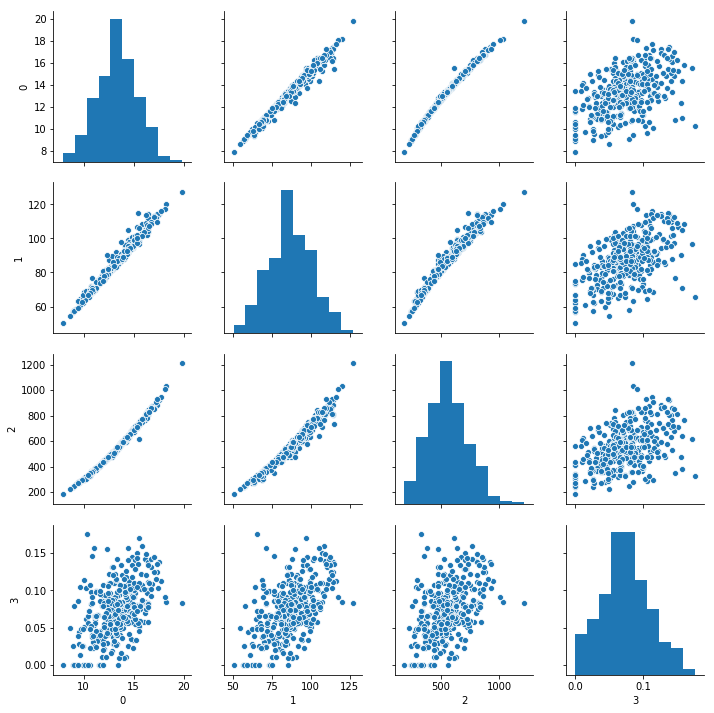

In [25]:
# A decent portion of the features seem to be correlated with each other - feature 1,2,3 not 4
# This makes me believe that the multivariate model will perform better than the simple model
all_features_norm = pd.DataFrame(final_features_normal)
g = sns.pairplot(all_features_norm)

In [26]:
"""
Returns a vector of all mu values for all distributions in vector of shape (4,1)
input train.shape = (m,4)
"""
def get_mu_vect(train):
    mu = np.mean(train,axis=0)
    mu.shape = (4,1)
    return mu

In [27]:
"""
Returns sigma, shape = (4,4)
"""
def get_sigma(train,mu):
    m = train.shape[0]
    sigma = np.zeros((4,4))
    for i in range(m):
        x = train[i,:]
        x.shape = (4,1)
        addition = np.dot((x - mu),(x - mu).T)
        sigma = sigma + addition
    return (1/m) * sigma

In [28]:
"""
Returns the probability for a given data point shape(4,1), given the multivariate distribution
"""
def get_multi_prob(x,mu,sigma):
    det = np.linalg.det(sigma)
    sigma_inv = np.linalg.inv(sigma)
    n = 4 # number of parameters
    ret = (1/(((2*math.pi)**(n/2))*(det**(1/2)))) * np.exp((-1/2)*np.dot(np.dot((x-mu).T,sigma_inv),(x-mu)))
    return np.asscalar(ret)

In [29]:
"""
Loops through the list of input data and returns a list of probabilities
"""
def get_multi_preds(data,mu,sigma):
    probs = []
    no_data = data.shape[0]
    for i in range(no_data):
        x = data[i,:]
        x.shape = (4,1)
        prob = get_multi_prob(x,mu,sigma)
        probs.append(prob)
    return probs

In [30]:
"""
Returns a list of probabilities for cv and test sets, along with estimates of whether they are normal or anomalies
"""
def multi_model(train,test,cv,epsilon=0.1):
    mu = get_mu_vect(train)
    sigma = get_sigma(train,mu)
    cv_prob = get_multi_preds(cv,mu,sigma)
    cv_disc = get_discrete_guess(cv_prob,epsilon)
    test_prob = get_multi_preds(test,mu,sigma)
    test_disc = get_discrete_guess(test_prob,epsilon)
    
    return cv_prob,cv_disc,test_prob,test_disc

In [31]:
cv_prob_m,cv_disc_m,test_prob_m,test_disc_m = multi_model(normal_X_train,norm_X_test,norm_X_cv,epsilon=4.03e-07)

In [32]:
# Testing the performance of the multivariate model using epsilon value from previous model
# We can see that there is better performance on the test set, but worse performance on cv set
print("f1 score for cv data:",f1_score(norm_y, cv_disc_m))
print("f1 score for test data:",f1_score(norm_y, test_disc_m))

f1 score for cv data: 0.7777777777777777
f1 score for test data: 0.9473684210526316


In [33]:
# Statistics for the multivariate model:
# cv stats for normal values
print("Minimum prob of normal cv values",np.min(cv_prob_m[:54]))
print("Maximum prob of normal cv values",np.max(cv_prob_m[:54]))
print("Average prob of normal cv values",np.mean(cv_prob_m[:54]))
# cv stats for anomaly values
print("--------")
print("Minimum prob of anomaly cv values",np.min(cv_prob_m[54:]))
print("Maximum prob of anomaly cv values",np.max(cv_prob_m[54:]))
print("Average prob of anomaly cv values",np.mean(cv_prob_m[54:]))

Minimum prob of normal cv values 6.695675955846957e-17
Maximum prob of normal cv values 0.010024181044861864
Average prob of normal cv values 0.003568524102962548
--------
Minimum prob of anomaly cv values 9.824924359864361e-172
Maximum prob of anomaly cv values 0.00011398664102008664
Average prob of anomaly cv values 1.373623146218139e-05


In [34]:
# Trying a new value to determine if better performance can be achieved
cv_prob_m,cv_disc_m,test_prob_m,test_disc_m = multi_model(normal_X_train,norm_X_test,norm_X_cv,epsilon=4.85e-06)
print("f1 score for cv data:",f1_score(norm_y, cv_disc_m))
print("f1 score for test data:",f1_score(norm_y, test_disc_m))

f1 score for cv data: 0.8421052631578948
f1 score for test data: 0.8571428571428572


Ultimately, it seems after playing around with values that the multivariate and normal gaussian models perform relatively similarly. The multivariate model has a lower variance and higher bias, while the normal model has lower bias and higher variance.